In [3]:
import math
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras as kr

from inefficient_networks import utils
from inefficient_networks.config import config 

config.set_matplotlib()
config.set_tensorflow_seeds(42)
config.set_ignore_warnings()
print(config.list_tensorflow_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.8.0


In [2]:
class ActivationFunction(kr.layers.Layer):
    def __init__(self):
        super().__init__()

# Test
a = ActivationFunction()
a.get_config()

{'name': 'activation_function', 'trainable': True, 'dtype': 'float32'}

In [3]:
class Sigmoid(ActivationFunction):
    def call(self, x):
        return 1 / (1 + tf.math.exp(-x))

    
class Tanh(ActivationFunction):
    def call(self, x):
        exp_x, exp_neg_x = tf.math.exp(x), tf.math.exp(-x)
        return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)

In [4]:
class ReLU(ActivationFunction):
    def call(self, x):
        return tf.where(x > 0, x, [0])
    

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = tf.Variable(alpha, trainable=False)
    
    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha})
        return config

    def call(self, x):
        return tf.where(x > 0, x, x * self.get_config()["alpha"])


class ELU(ActivationFunction):
    def call(self, x):
        # For some reason `tf.exp(x) - c` is not registered in the GPU
        return tf.where(x > 0, x, tf.exp(x) + (-1.0))
    

class Swish(ActivationFunction):
    def call(self, x):
        return x * kr.activations.sigmoid(x)

In [5]:
activation_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

In [6]:
def get_grads(activation, x):
    """Compute gradient of activation with respect to x."""
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = activation_by_name[activation]()(x)
        z = tf.reduce_sum(y)

    # Trick: ∂(y1 + y2)/∂x1 = ∂y1/∂x1 stored in x1.
    return tape.gradient(z, x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-16 02:12:20.383314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 02:12:20.383427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


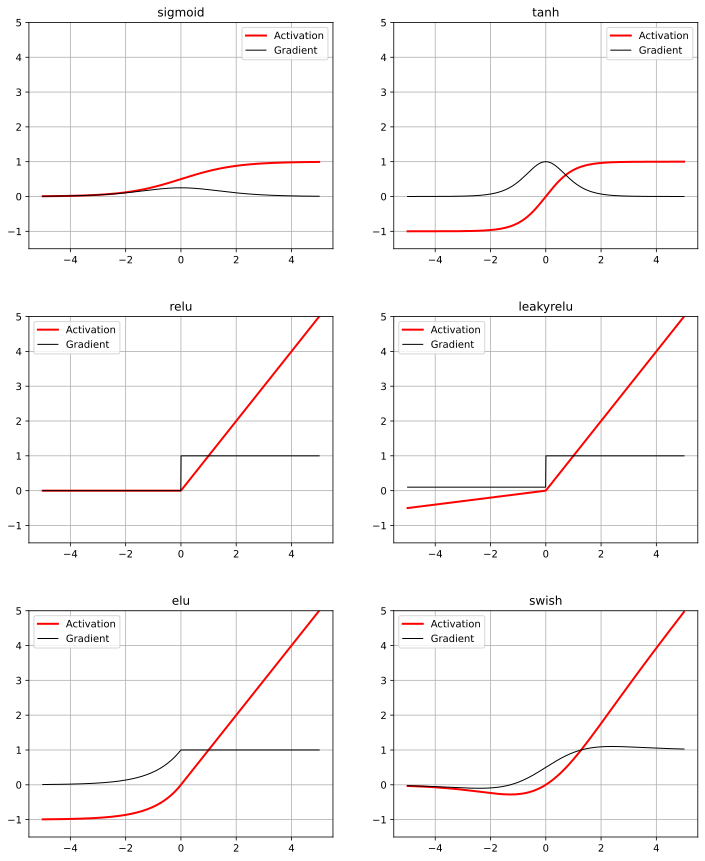

In [7]:
def plot_activation(activation, ax, x):
    """Plot (x, activation(x)) on axis object ax."""

    # Get output and gradients from input space x.
    y = activation_by_name[activation]()(x)
    y_grads = get_grads(activation, x)

    # Convert to numpy for plotting
    x, y, y_grads = x.numpy(), y.numpy(), y_grads.numpy()
    
    # Plotting
    ax.plot(x, y, linewidth=2, color='red', label="Activation")
    ax.plot(x, y_grads, linewidth=1, color='black', label="Gradient")
    ax.set_title(activation)
    ax.legend()
    ax.grid()
    ax.set_ylim(-1.5, x.max())


# Plotting
x = tf.reshape(tf.linspace(-5, 5, 1000), (-1, 1))
rows = math.ceil(len(activation_by_name.keys()) / 2.0)
fig, ax = plt.subplots(rows, 2, figsize=(12, rows*5))
for i, activation in enumerate(activation_by_name.keys()):
    plot_activation(activation, ax[divmod(i, 2)], x) # divmod(m, n) = m // n, m % n

fig.subplots_adjust(hspace=0.3)
plt.show()

In [14]:
def nin_block(activation, channels, kernel_size, strides, padding):
    block = kr.Sequential([
        kr.layers.ZeroPadding2D(padding),
        kr.layers.Conv2D(channels[0], kernel_size, strides=strides),
        activation_by_name[activation](),
        kr.layers.Conv2D(channels[1], kernel_size=1),
        activation_by_name[activation](),
        kr.layers.Conv2D(channels[2], kernel_size=1),
        activation_by_name[activation](),
    ])
    return block


def base_convnet(activation):
    """Return a convolutional network with given activation and layer widths."""

    # Add dense hidden layers + activation layer
    model = kr.Sequential([
        nin_block(activation, [96, 80, 48], 5, 1, 2),
        kr.layers.ZeroPadding2D(1),
        kr.layers.MaxPool2D(pool_size=3, strides=2),
        kr.layers.Dropout(0.5),

        nin_block(activation, [96, 96, 96], 5, 1, 2),
        kr.layers.ZeroPadding2D(1),
        kr.layers.AvgPool2D(pool_size=3, strides=2),
        kr.layers.Dropout(0.5),

        nin_block(activation, [96, 96, 10], 3, 1, 1),
        kr.layers.AvgPool2D(pool_size=8),
        
        kr.layers.Flatten(),
        kr.layers.Softmax()
    ])

    return model


model = base_convnet(activation='relu')
model.build(input_shape=(None, 32, 32, 3))
model.summary()

x = tf.random.normal(shape=(256, 32, 32, 3))
tf.print(model(x).shape)
tf.print(model(x)[0])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32, 32, 48)        18944     
                                                                 
 zero_padding2d_11 (ZeroPadd  (None, 34, 34, 48)       0         
 ing2D)                                                          
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 48)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 48)        0         
                                                                 
 sequential_9 (Sequential)   (None, 16, 16, 96)        133920    
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 18, 18, 96)     

In [15]:
CIFAR10 = tfds.load(
    'cifar10', 
    data_dir=config.DATASET_DIR, 
    shuffle_files=False
)

In [16]:
# Transformations applied on each image. 
def transform_image(image):
    """Rescale image linearly from [0, 255] to [0, 1]."""
    return kr.layers.Rescaling(1./255)(image)

train_ds, other_ds = CIFAR10['train'], CIFAR10['test']
train_ds = train_ds.map(lambda x: (transform_image(x['image']), x['label']))
other_ds = other_ds.map(lambda x: (transform_image(x['image']), x['label']))

# Create fixed batch for all subsequent experiments
fixed_batch = next(iter(train_ds.batch(4096)))

# Data loaders
train_ds = train_ds.shuffle(1000).batch(256, drop_remainder=True)
valid_ds = other_ds.batch(256, drop_remainder=False).take(20)
test_ds = other_ds.batch(256, drop_remainder=False).skip(20)

2022-05-16 02:52:37.932892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

horse


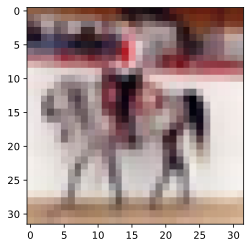

In [18]:
plt.imshow(fixed_batch[0][0]);
print(class_names[fixed_batch[1][0].numpy()])

In [ ]:
def run_training(activation, epochs=30):

    model = base_convnet(activation=activation)
    model.compile(
        optimizer=kr.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    hist = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=valid_ds
    )

    test_acc = model.evaluate(test_ds)[1]
    return hist, test_acc


epochs = 100
num_trials = 5
start = 1
activations = activation_by_name.keys()
for i in range(start, start + num_trials):
    for activation in activations:
        hist, test_acc = run_training(activation, epochs)
        
        hist_df = pd.DataFrame(hist.history)
        hist_df.to_csv(activation + f'-hist-trial{i}.csv', index=False)

        test_acc_df = pd.DataFrame({'test_acc': [test_acc]})
        test_acc_df.to_csv(activation + f'-testacc-trial{i}.csv', index=False)
        

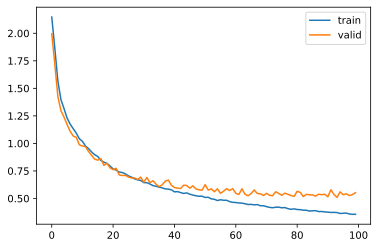

In [4]:
hist_df = pd.read_csv('trial1-hist/relu-hist-trial1.csv')
plt.plot(hist_df.loss, label='train')
plt.plot(hist_df.val_loss, label='valid')
plt.legend()

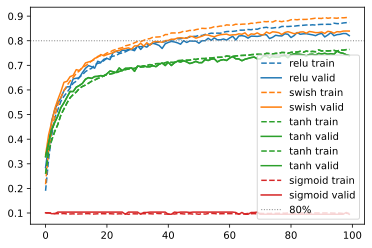

In [27]:
hist_df = pd.read_csv('trial1-hist/relu-hist-trial1.csv')
plt.plot(hist_df.accuracy, label='relu train', color='C0', linestyle='dashed')
plt.plot(hist_df.val_accuracy, label='relu valid', color='C0')
plt.legend();

hist_df = pd.read_csv('trial1-hist/swish-hist-trial1.csv')
plt.plot(hist_df.accuracy, label='swish train', color='C1', linestyle='dashed')
plt.plot(hist_df.val_accuracy, label='swish valid', color='C1')
plt.legend();

hist_df = pd.read_csv('trial1-hist/tanh-hist-trial1.csv')
plt.plot(hist_df.accuracy, label='tanh train', color='C2', linestyle='dashed')
plt.plot(hist_df.val_accuracy, label='tanh valid', color='C2')
plt.legend();

hist_df = pd.read_csv('trial1-hist/tanh-hist-trial1.csv')
plt.plot(hist_df.accuracy, label='tanh train', color='C2', linestyle='dashed')
plt.plot(hist_df.val_accuracy, label='tanh valid', color='C2')
plt.legend();

hist_df = pd.read_csv('trial1-hist/sigmoid-hist-trial1.csv')
plt.plot(hist_df.accuracy, label='sigmoid train', color='C3', linestyle='dashed')
plt.plot(hist_df.val_accuracy, label='sigmoid valid', color='C3')
plt.legend();

plt.axhline(0.8, color='gray', linestyle='dotted', linewidth=1, label="80%")
plt.legend();

In [12]:
pd.read_csv('trial1-test/relu-testacc-trial1.csv')

,test_acc
0,0.811066
